In [1]:
import numpy as np
import subprocess
import os
import sys
import shutil
import matplotlib.pyplot as plt

## Funciones para comparar + recursos

In [2]:
# CONSTANTES
filters_makefile = './filters/Makefile'
optimizaciones = ['O0', 'O1', 'O2', 'O3', 'Ofast', 'Og', 'Os']
ejecutable = './build/tp2-custom'

In [3]:
def clean_build():
    """
    Limpia la carpeta build
    """
    !make clean > /dev/null

In [4]:
def reset_default():
    """
    Copia el Makefile original a la carpeta filters
    """
    new_makefile = './makefiles/O0.Makefile'
    shutil.copy2(new_makefile, filters_makefile)

In [5]:
def build(optimizacion = 'O0'):
    """
    Compila el programa con la optimización correcta si existe el archivo Makefile.
    
    Las opciones son: O0, O1, O2, O3, Ofast, Og, Os
    """
    clean_build()
    new_makefile = f'./makefiles/{optimizacion}.Makefile'
    if not os.path.isfile(new_makefile):
        raise ValueError(f'El archivo {new_makefile} no existe')
    shutil.copy2(new_makefile, filters_makefile)
    !make -f Makefile.custom > /dev/null
    reset_default()

In [6]:
def correr_instancia(filtro, archivo_entrada, implementacion, cant_iteraciones = '50'):
    """
    Aplica el filtro a la imagen de entrada y devuelve un array con la cantidad de ticks de reloj por cada iteración.
    
    Guarda la imagen de prueba en la carpeta build
    """
    result = subprocess.run([ejecutable, filtro, archivo_entrada, '-i', implementacion, '-t', cant_iteraciones, '-o', 'build/'], capture_output=True,  encoding='utf-8')
    # print(result)
    output = result.stdout.split('\n')[:-1]
    output = output[4]
    return np.array(list(map(int, output.split(','))))

In [7]:
def graficar_boxplots(data, labels, title):
    fig = plt.figure(figsize =(15, 15))
    ax = fig.add_subplot(111)

    bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 0)
    
    # x-axis labels
    ax.set_yticklabels(labels)
    
    # Adding title 
    plt.title(title)
    plt.ylabel('Implementaciones')
    plt.xlabel('Ticks de reloj')


    plt.show(bp)

In [8]:
def comparar_c_asm(filtro, imagen, iteraciones = '50'):
    build()
    ticksASM = correr_instancia(filtro, imagen, 'asm', iteraciones)
    ticks = [ticksASM]
    for optimizacion in optimizaciones:
        build(optimizacion)
        ticks.append(correr_instancia(filtro, imagen, 'c', iteraciones))
    graficar_boxplots(ticks, ['ASM'] + optimizaciones, f'Comparación implementaciones filtro {filtro} - {imagen}')

In [9]:
def comparar_varios(info, imagen, iteraciones = '50'):
    ticks = []
    labels = []
    for filtro in info:
        build(filtro['optimizacion'])
        ticks.append(correr_instancia(filtro['nombre'], imagen, filtro['implementacion'], iteraciones))
        labels.append(filtro['nombre'] + '_' + filtro['implementacion'] + ' (' + filtro['optimizacion'] + ')')
    
    graficar_boxplots(ticks, labels, f'Comparación implementaciones filtros varios - {imagen}')

## Generación de imágenes

Generamos imágenes de tamaños:
- 32x16
- 800x600
- 1920x1200

de las imágenes "HardCandy.bmp" y "Labyrinth.bmp" en la carpeta img.

In [10]:
# Este script crea las multiples imagenes de prueba a partir de unas
# pocas imagenes base.

IMGDIR = "./img"

IMAGENES=["HardCandy.bmp","Labyrinth.bmp"]

sizes=['800x600', '1920x1200', '32x16']

for filename in IMAGENES:
    for size in sizes:
        sys.stdout.write(" " + size)
        name = filename.split('.')
        file_in = IMGDIR + "/" + filename
        file_out = IMGDIR + "/" + name[0] + "." + size + "." + name[1]
        resize = "convert -resize " + size + "! " + file_in + " " + file_out
        subprocess.call(resize, shell=True)

 800x600 1920x1200 32x16 800x600 1920x1200 32x16

## Comparaciones con su versión en C

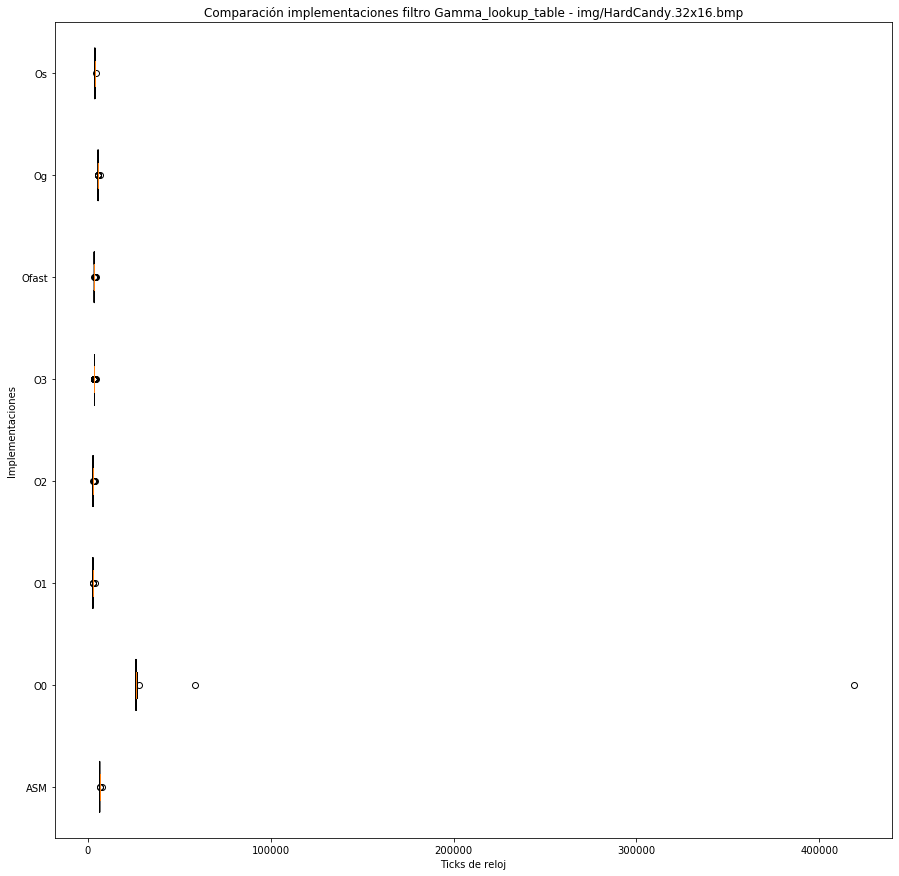

In [11]:
comparar_c_asm('Gamma_lookup_table', 'img/HardCandy.32x16.bmp')

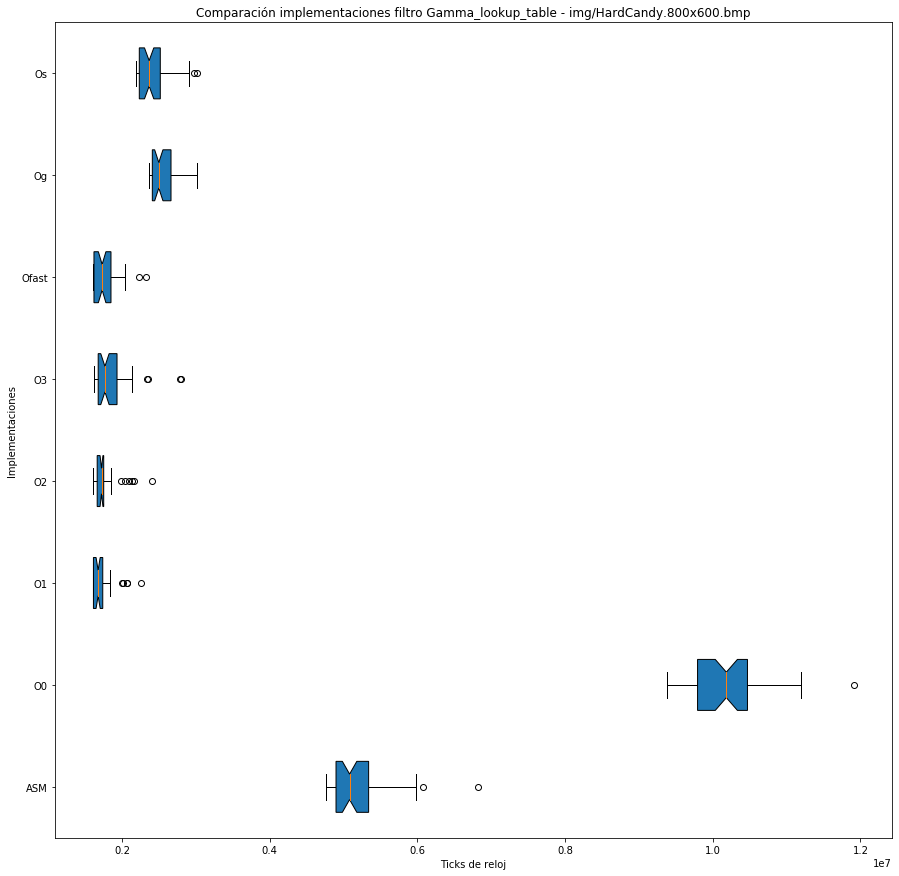

In [12]:
comparar_c_asm('Gamma_lookup_table', 'img/HardCandy.800x600.bmp')

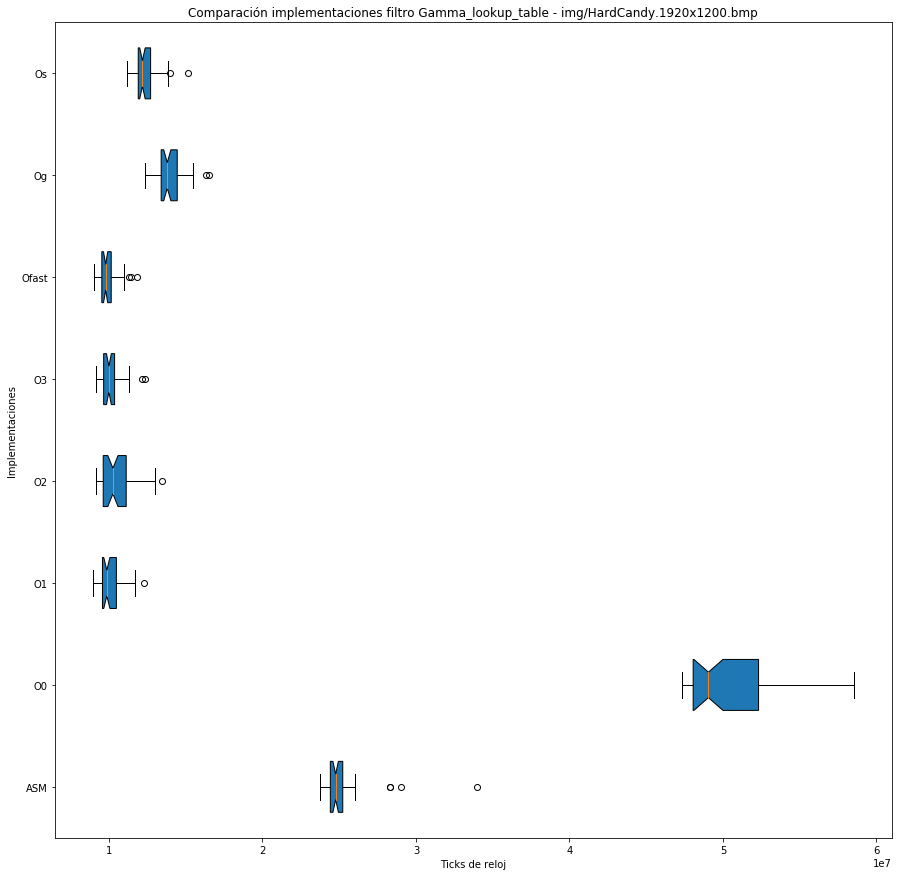

In [22]:
comparar_c_asm('Gamma_lookup_table', 'img/HardCandy.1920x1200.bmp')

## Comparaciones Gamma_lookup_table_ymm contra su versión en C

In [ ]:
comparar_c_asm('Gamma_lookup_table_ymm', 'img/HardCandy.32x16.bmp')

In [ ]:
comparar_c_asm('Gamma_lookup_table_ymm', 'img/HardCandy.800x600.bmp')

In [ ]:
comparar_c_asm('Gamma_lookup_table_ymm', 'img/HardCandy.1920x1200.bmp')

## Comparaciones con Gamma original

In [18]:
filtros_a_comparar = [{'nombre': 'Gamma', 'implementacion': 'asm', 'optimizacion': 'O0'}, 
                      {'nombre': 'Gamma_lookup_table', 'implementacion': 'asm', 'optimizacion': 'O0'}, 
                      {'nombre': 'Gamma_lookup_table', 'implementacion': 'c', 'optimizacion': 'O3'}, 
                      {'nombre': 'Gamma_lookup_table', 'implementacion': 'c', 'optimizacion': 'Ofast'}, 
                      ]

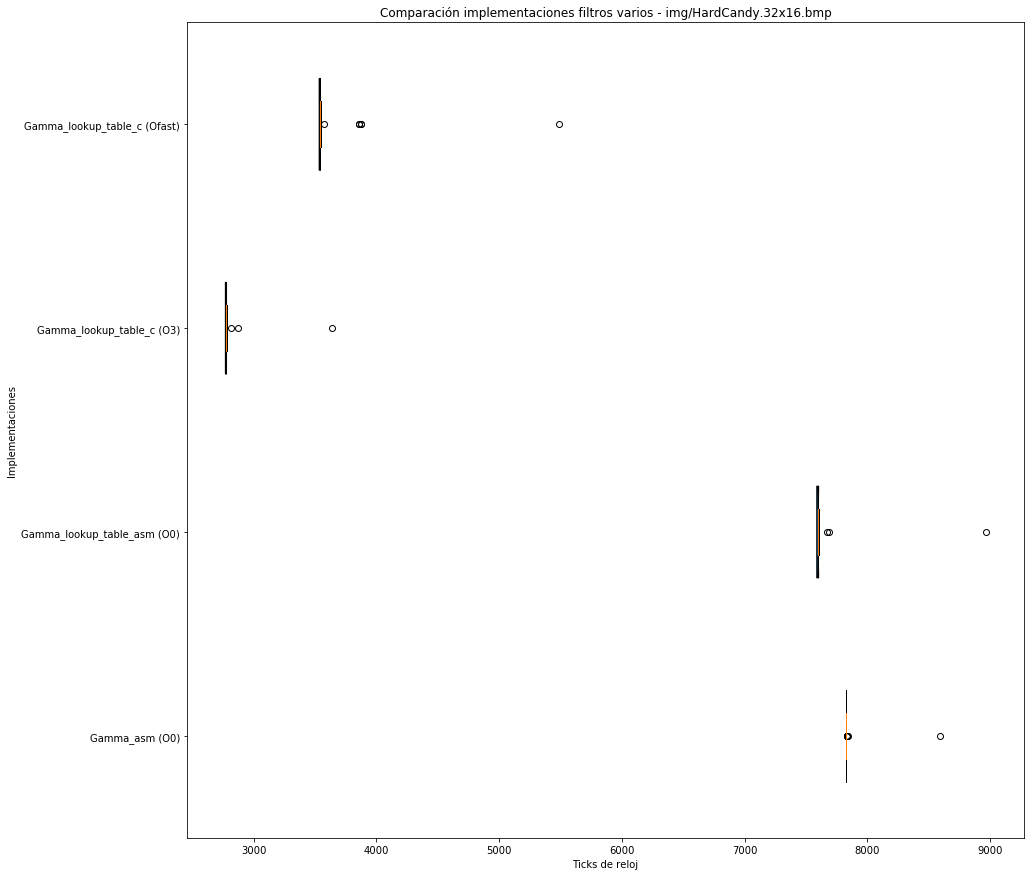

In [19]:
comparar_varios(filtros_a_comparar, 'img/HardCandy.32x16.bmp')

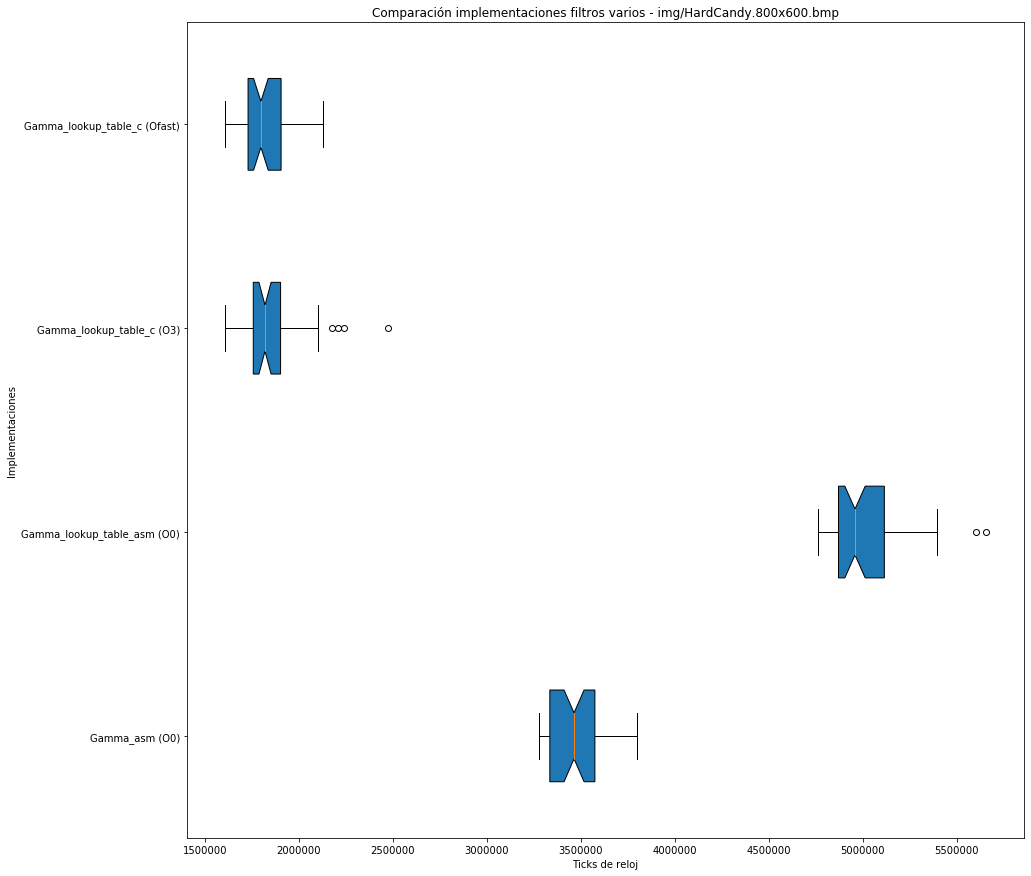

In [20]:
comparar_varios(filtros_a_comparar, 'img/HardCandy.800x600.bmp')

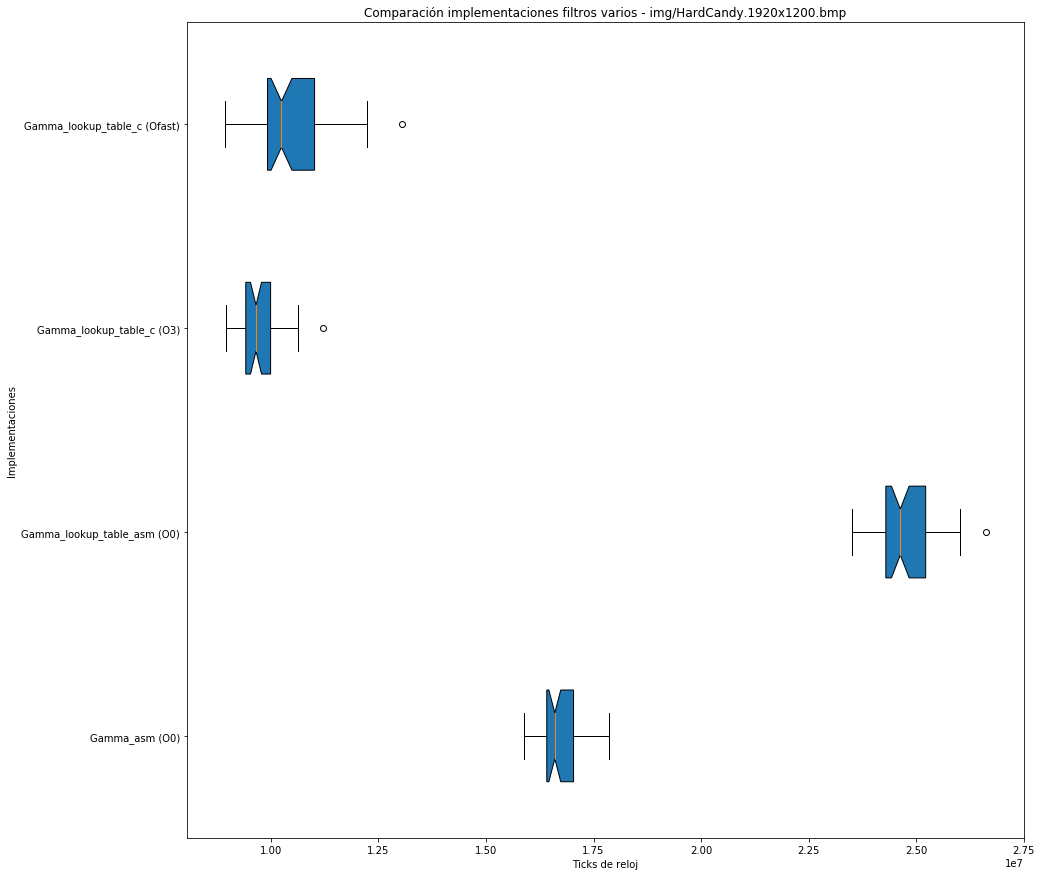

In [21]:
comparar_varios(filtros_a_comparar, 'img/HardCandy.1920x1200.bmp')